## 데이터 처리 Part

해당 부분은 데이터마이닝에서도 포함이 될 수는 있지만

일단은 통계분석으로 넣은 이유는 데이터 마이닝에서 해당 분석법이 안 쓰일 수 있고

일단 ADP 쪽 데이터마이닝에서의 핵심은 모델링이기 때문이다

그렇기에, 데이터마이닝에서도 포함이 되긴 하지만, 

통계분석에서도 해당 분석법을 사용하여서 분류분석 단계로 넘어갈 수 있을 정도의 분석법들을 정리하고자 한다.

총 항목은 5개로 

1. 결측치 시각화 및 피벗테이블 등 통계분석시 나올 만한 가공법

2. 값 scaling

3. PCA, FA

4. 군집분석 Kmeans

5. 반응변수 샘플링(under, over, smote)

로 진행해보려 한다.

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 30)
from pandas import DataFrame

import warnings
warnings.filterwarnings("ignore")

## 결측치 시각화 및 처리, 피벗테이블 등 데이터 가공

간단한 EDA로 데이터의 결측치를 시각화 하고 제거하거나 대체하는 방법을 간단하게 해놓고

이러한 류의 데이터가 아닌 피벗테이블 같은 방식으로 그룹화를 해서 진행을 해야될 경우를 위하여

피벗테이블로 가공을 하는 방법도 해놓았다.

데이터는 타이타닉 데이터를 사용하였고, 다운을 받으려면 https://www.kaggle.com/c/titanic/data 에서 받기 바랍니다.

In [2]:
train = pd.read_csv("train.csv")
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


missingno 패지키를 사용하면 전체 데이터에서 결측치가 있는 부분은 흰색 선이 나오고

값이 있는 데이터는 정상적인 검정색으로 나온다

<AxesSubplot:>

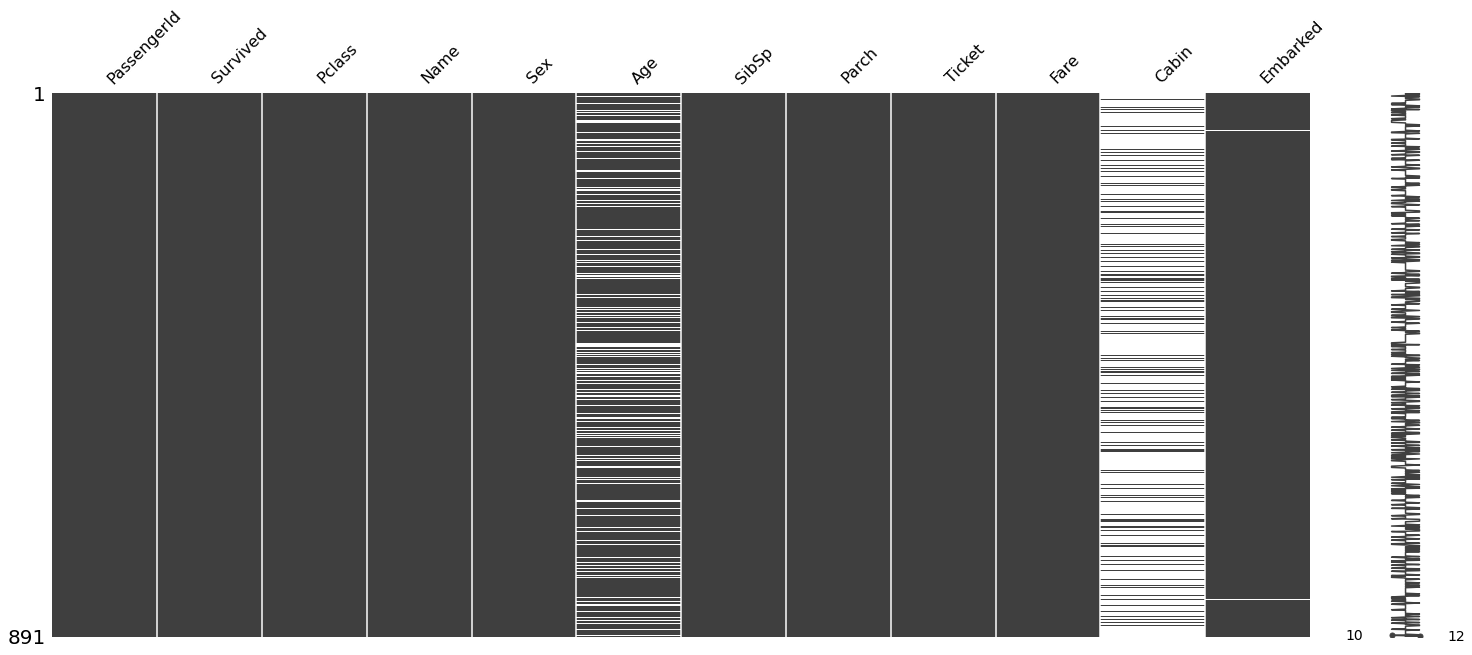

In [3]:
import missingno

missingno.matrix(train)

전체 데이터에서의 null의 총 갯수를 보고 싶으면 isnull을 쓰고 sum을 하면 된다

In [4]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age 같은 경우는 그나마 결측치 비율이 작으므로 평균 값으로 대체를 하고 진행을 해보았다

In [5]:
train.loc[train.isnull()['Age'],'Age'] = train['Age'].mean()

train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Cabin은 결측치가 많으므로 해당 열을 삭제하고 Embarked의 경우 2개만 결측치이므로 dropna로 해당 열만 삭제하였다

In [6]:
train2 = train.drop(columns=['Cabin']).dropna(axis=0)

train2.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

그 다음으로는 피벗테이블화 시켜서 그룹별로 원하는 값을 뽑아내는 방법입니다.

피벗테이블로 성별, 생존별 나이의 중앙값을 구한 방법입니다.

margins를 사용하는 경우, 전체에 대한 것도 같이 구해줍니다.

In [7]:
pivot1 = pd.pivot_table(train2, index='Sex', columns='Survived', values='Age', aggfunc='mean', margins=True)
pivot1

Survived,0,1,All
Sex,,,
female,26.023272,28.797265,28.077094
male,31.175224,27.631705,30.505824
All,30.415100,28.423600,29.653446


만든 피벗 테이블에 unstack이나 stack을 해주면 해당 인덱스와 컬럼이 series 형식으로 풀리며

이 상황에서 reset_index를 해주면 피벗테이블을 만들면서 넣은 열들의 그룹별로의 값이 담긴 DataFrame이 만들어진다

In [8]:
pivot1.unstack().reset_index()

,Survived,Sex,0
0,0,female,26.023272
1,0,male,31.175224
2,0,All,30.415100
3,1,female,28.797265
4,1,male,27.631705
5,1,All,28.423600
6,All,female,28.077094
7,All,male,30.505824
8,All,All,29.653446


In [9]:
pivot1.stack().reset_index()

,Sex,Survived,0
0,female,0,26.023272
1,female,1,28.797265
2,female,All,28.077094
3,male,0,31.175224
4,male,1,27.631705
5,male,All,30.505824
6,All,0,30.415100
7,All,1,28.423600
8,All,All,29.653446


피벗 테이블을 단순하게 만드는 것이 아닌, 여러 열을 더 넣고 하려면 list 안에 넣고 하면 된다

In [10]:
pd.pivot_table(train2, index=['Sex','Parch'], columns='Survived', values='Age', aggfunc='median')

Survived              0          1
Sex    Parch                      
female 0      28.000000  29.699118
       1      28.500000  28.349559
       2      16.000000  22.000000
       3      48.000000  24.000000
       4      37.000000        NaN
       5      39.000000  38.000000
       6      43.000000        NaN
male   0      29.699118  29.699118
       1      28.000000   6.000000
       2      26.000000   3.500000
       3      16.000000        NaN
       4      52.000000        NaN
       5      39.000000        NaN

In [11]:
pd.pivot_table(train2, index=['Sex','Parch'], columns=['Survived','SibSp'], values=['Age','Fare'], aggfunc='median')

Age                                                    \
Survived              0                                                     
SibSp                 0          1     2          3    4     5          8   
Sex    Parch                                                                
female 0      29.699118  27.000000  18.0        NaN  NaN   NaN        NaN   
       1      18.000000  28.500000   NaN  29.699118  NaN   NaN        NaN   
       2      29.699118  25.000000  15.0   5.500000  7.5  16.0  29.699118   
       3            NaN  48.000000   NaN        NaN  NaN   NaN        NaN   
       4      29.000000  45.000000   NaN        NaN  NaN   NaN        NaN   
       5      40.000000  39.000000   NaN        NaN  NaN   NaN        NaN   
       6            NaN  43.000000   NaN        NaN  NaN   NaN        NaN   
male   0      29.699118  29.699118  28.0        NaN  NaN   NaN        NaN   
       1      40.000000  33.000000  23.0  15.849559  7.0   NaN        NaN   
       2      38.500000  27.849559   NaN  10.000000  6.5  10.0  29.699118   
       3            NaN  16.000000   NaN        NaN  NaN   NaN        NaN   
       4            NaN  52.000000   NaN        NaN  NaN   NaN        NaN   
       5            NaN  39.000000   NaN        NaN  NaN   NaN        NaN   

                                                               Fare            \
Survived              1                                           0             
SibSp                 0          1          2     3     4         0         1   
Sex    Parch                                                                    
female 0      29.699118  29.699118  41.349559  31.5   NaN   8.05000   14.4583   
       1      25.000000  34.500000   4.000000   NaN   NaN  14.45420   15.3729   
       2      23.000000  23.000000  19.500000  23.5  11.0  17.72915  151.5500   
       3      24.000000  54.000000  24.000000   NaN   NaN       NaN   34.3750   
       4            NaN        NaN        NaN   NaN   NaN  21.07500   27.9000   
       5            NaN  38.000000        NaN   NaN   NaN  34.40625   31.2750   
       6            NaN        NaN        NaN   NaN   NaN       NaN   46.9000   
male   0      29.699118  31.500000  39.849559   NaN   NaN   8.05000   21.0000   
       1      14.500000   6.000000   1.000000   NaN   NaN  61.67920   24.1500   
       2       4.000000   6.000000        NaN   NaN   3.0  69.63750   25.6000   
       3            NaN        NaN        NaN   NaN   NaN       NaN   34.3750   
       4            NaN        NaN        NaN   NaN   NaN       NaN  145.4500   
       5            NaN        NaN        NaN   NaN   NaN       NaN   31.2750   

                                                                             \
Survived                                                       1              
SibSp               2         3         4     5      8         0          1   
Sex    Parch                                                                  
female 0      18.0000       NaN       NaN   NaN    NaN  13.00000   52.55000   
       1          NaN  25.46670       NaN   NaN    NaN  33.00000   29.50000   
       2      34.3750  27.90000  31.27500  46.9  69.55  24.17915   53.28960   
       3          NaN       NaN       NaN   NaN    NaN  19.25830   23.00000   
       4          NaN       NaN       NaN   NaN    NaN       NaN        NaN   
       5          NaN       NaN       NaN   NaN    NaN       NaN   31.38750   
       6          NaN       NaN       NaN   NaN    NaN       NaN        NaN   
male   0      21.6792       NaN       NaN   NaN    NaN  13.43125   54.27085   
       1      11.5000  23.27085  39.68750   NaN    NaN  37.91665   17.32500   
       2          NaN  27.90000  31.33125  46.9  69.55  37.00420  120.00000   
       3          NaN       NaN       NaN   NaN    NaN       NaN        NaN   
       4          NaN       NaN       NaN   NaN    NaN       NaN        NaN   
       5          NaN       NaN       NaN   NaN    NaN       NaN    

## 값 scaling

값 scaling 같은 경우는 각 변수들마다 평균과 분산의 크기가 다른 경우가 많을텐데

표준화 단계를 통해서 데이터의 왜곡으로 인한 문제를 피할 수 있게 해줍니다.

train, test로 나누어서 scaling을 할 때에는 train의 값을 이용해서

test data에 적용을 해줘야지, train은 train끼리 test는 test끼리 적용을 하면 안됩니다.

In [12]:
f_train = pd.read_csv("https://rfriend.tistory.com/attachment/cfile21.uf@2577A64555C56ECF0CF0C8.csv",
           encoding='cp949')
del f_train['company']
f_train.head()

,V1,V2,V3,V4,V5
0,2.43,11.10,18.46,441.67,0.90
1,3.09,9.95,29.46,239.43,0.90
2,2.22,6.86,28.62,249.36,0.69
3,5.76,23.19,23.47,326.09,1.43
4,1.60,5.64,25.64,289.98,1.42


MinMaxScaler는 최소값과 최대값을 각각 0과 1이 되게 해주는 스케일링이며

StandardScaler는 평균과 표준편차를 이용해서 하는 방법이다.

test data에 적용하고 싶은 경우는 Scaler에 transform(test_data)를 하면 된다

In [13]:
from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler()

standardScaled = standardScaler.fit_transform(f_train)

scaled_data = DataFrame(standardScaled, columns=f_train.columns)
scaled_data.head()

,V1,V2,V3,V4,V5
0,-0.548158,0.393974,-0.944859,1.377781,0.052140
1,0.049833,0.134995,-0.320690,-0.077102,0.052140
2,-0.738427,-0.560872,-0.368354,-0.005667,-0.545097
3,2.468975,3.116637,-0.660579,0.546316,1.559452
4,-1.300176,-0.835615,-0.537447,0.286547,1.531012


In [14]:
scaled_data.describe().iloc[0:3]

,V1,V2,V3,V4,V5
count,1.800000e+01,1.800000e+01,1.800000e+01,18.000000,1.800000e+01
mean,2.097088e-16,8.635068e-17,-2.898916e-16,0.000000,1.788693e-16
std,1.028992e+00,1.028992e+00,1.028992e+00,1.028992,1.028992e+00


표본 갯수가 애초에 작아서 std가 값이 1보다는 살짝은 큰 모습입니다.

하지만 어느정도 평균은 0에 가까운 모습을 보이고 있기에

원하는 대로 scaling이 완료된 모습입니다.

In [15]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

MinMax_train = min_max_scaler.fit_transform(f_train)

MinMax_train = DataFrame(MinMax_train, columns=f_train.columns)
MinMax_train.head()

,V1,V2,V3,V4,V5
0,0.199519,0.381269,0.018769,0.927889,0.595420
1,0.358173,0.322416,0.225225,0.459112,0.595420
2,0.149038,0.164278,0.209459,0.482129,0.435115
3,1.000000,1.000000,0.112800,0.659983,1.000000
4,0.000000,0.101842,0.153529,0.576283,0.992366


In [16]:
MinMax_train.describe().T[['min','max']]

,min,max
V1,0.0,1.0
V2,0.0,1.0
V3,0.0,1.0
V4,0.0,1.0
V5,0.0,1.0


최소값과 최대값이 확실히 0과 1인 것을 확인할 수 있습니다.

둘 중 제시되는 방법을 사용하시거나

둘을 비교하는 문제가 나올 경우에는 둘 다 수행한 뒤에

생각하시는 장단점을 서술하는 방식으로 하시면 될 듯 합니다.

## PCA & FA

이 둘의 차이점에 대한 포스팅은

https://ysyblog.tistory.com/124 해당 블로그를 보시면 자세히 보실 수 있습니다

PCA는 데이터 마이닝쪽에서 나올 가능성이 높고, 

만약에 나온다면 PCA에 사용된 변수들은 버리고 pca로 나온 변수들을 사용해서 하면 됩니다.

FA가 나온다면 통계분석 영역에서 나올 가능성이 높습니다.

굳이 pca가 있는데 fa를 머신러닝에서 사용하는 경우는 본 적이 없습니다.

PCA

표준화 된 데이터로 학습을 시키고 pca componenents의 구성요소대로 변환을 수행한 다음에 score에 저장합니다.

pca.components_로 변수들이 어떻게 묶였는지 볼 수는 있지만

높은 값을 가지고 있는 변수들 끼리 묶어서 어떠한 변수로 이름을 지어보겠다는 가능하지

높은 값을 가진 것들만 사용하는 것은 안됩니다.

In [17]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(scaled_data )

score = pca.transform(scaled_data)

pca.components_

array([[ 0.07608427, -0.39463007,  0.56970191, -0.5598277 , -0.44778451],
       [ 0.77966993,  0.56541218,  0.16228156, -0.19654293,  0.08636803],
       [ 0.0008916 , -0.29532165,  0.24122211, -0.25659729,  0.88811827],
       [ 0.1407554 , -0.11764417,  0.63772189,  0.74809431,  0.00366842],
       [-0.60540325,  0.65078503,  0.42921686, -0.14992183,  0.05711464]])

ratio는 각 주성분들이 전체 데이터에서 가지고 있는 분산 비율입니다.

제2주성분까지 합쳐보면 약 87퍼입니다.

In [18]:
ratio = pca.explained_variance_ratio_
ratio

array([0.55229245, 0.32113064, 0.11011261, 0.01281263, 0.00365167])

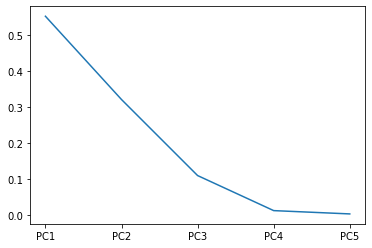

In [19]:
import matplotlib.pyplot as plt

ax = plt.plot(['PC1','PC2','PC3','PC4','PC5'], ratio)
plt.show()

주성분에서 몇 개의 주성분까지만 선택할 고르는 방법은 기울기가 완만해지는 시점이나

전체 분산 비율이 70퍼에서 90퍼 정도 사이에 있으면 분석가의 판단하에 선택합니다.

3개를 선택해도 되긴 하지만 일단 2개만 선택하도록 하겠습니다.

In [20]:
pca = PCA(n_components=2)

pca_data = pca.fit_transform(scaled_data )

DataFrame(pca_data, columns=['PC1','PC2']).head()

,PC1,PC2
0,-1.530135,-0.624247
1,-0.212363,0.082795
2,0.202561,-0.998596
3,-2.422543,3.607282
4,-0.921329,-1.497481


FA

같은 데이터로 FA도 해보고 싶지만, 원하는 방식대로 결과가 나오지 않아서

다른 데이터를 가지고 와서 수행하였습니다.

In [21]:
from factor_analyzer import FactorAnalyzer
df = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/psych/bfi.csv",
                index_col=0)
df.drop(['gender','education','age'],axis=1,inplace=True)
df.dropna(inplace=True)
df.head(2)

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,E1,E2,E3,E4,E5,N1,N2,N3,N4,N5,O1,O2,O3,O4,O5
61617,2.0,4.0,3.0,4.0,4.0,2.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,4.0,4.0,3.0,4.0,2.0,2.0,3.0,3.0,6,3.0,4.0,3.0
61618,2.0,4.0,5.0,2.0,5.0,5.0,4.0,4.0,3.0,4.0,1.0,1.0,6.0,4.0,3.0,3.0,3.0,3.0,5.0,5.0,4.0,2,4.0,3.0,3.0


요인성 평가

1. Bartlett test

귀무가설 :  탐색적 요인 분석에 적합한 데이터가 아니다.

2. kmo 검정 (변수 최소 3개)

관측된 모든 변수간 분산 비율 추정

0.6미만은 부적절, 0.8이상은 우수

In [22]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

calculate_bartlett_sphericity(df)

(18170.966350869257, 0.0)

In [23]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df)

kmo_model

0.848539722194922

요인 수 선택

eigen value가 1이상일때 까지 혹은 기울기가 완만해지는 시점까지 진행

In [24]:
fa = FactorAnalyzer(n_factors = df.shape[1], rotation=None)
fa.fit(df)

ev, v = fa.get_eigenvalues()
ev

array([5.13431118, 2.75188667, 2.14270195, 1.85232761, 1.54816285,
       1.07358247, 0.83953893, 0.79920618, 0.71898919, 0.68808879,
       0.67637336, 0.65179984, 0.62325295, 0.59656284, 0.56309083,
       0.54330533, 0.51451752, 0.49450315, 0.48263952, 0.448921  ,
       0.42336611, 0.40067145, 0.38780448, 0.38185679, 0.26253902])

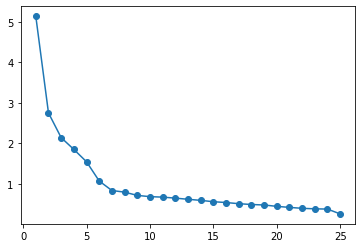

In [25]:
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)

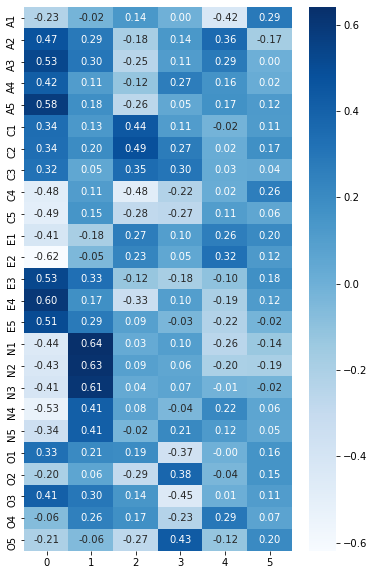

In [26]:
import seaborn as sns

fa = FactorAnalyzer(n_factors = 6, rotation=None)
fa.fit(df)

efa_result = pd.DataFrame(fa.loadings_, index = df.columns)

plt.figure(figsize=(6,10))
sns.heatmap(efa_result, annot=True, cmap='Blues', fmt='.2f');

0부터 5까지 중에서

각각 0은 N, 1은 E, 2는 C, 3은 A, 4는 O에 대해서 높은 요인 적재량을 가진다

In [27]:
fa = FactorAnalyzer(n_factors = 5, rotation='varimax') #최대 우도 방법
fa.fit(df)

df1 = pd.DataFrame(fa.get_factor_variance())

df1.index = ['SS Loading','Proportion Var','Cumulative Var'] # ss loading = 각 factor의 설명력
df1

,0,1,2,3,4
SS Loading,2.709633,2.473090,2.041106,1.844498,1.522153
Proportion Var,0.108385,0.098924,0.081644,0.073780,0.060886
Cumulative Var,0.108385,0.207309,0.288953,0.362733,0.423619


cf) 신뢰도 계수 구하기

In [28]:
def CronbachAlpha(item):
    item = np.asarray(item)
    itemvars = item.var(axis=0, ddof=1)
    tscores = item.sum(axis=1)
    nitems = item.shape[1]
    return (nitems/(nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1) ))

In [29]:
factors = ['A','C','E','N','O']
items_dict = {}
for factor in factors:
    items_dict[factor] = [x for x in df.columns if x[0] == factor]
    
for key, value in items_dict.items():
    print(key)
    print(CronbachAlpha(df[value]))
    print()

A
0.4437533019387808

C
-0.31628341382240494

E
-0.6552429584732491

N
0.8169468842774033

O
-0.176098107937655



마이너스가 아닌 N과 A가 신뢰도가 높다고 할 수 있는 듯 하다.

## 군집분석(Kmeans) (som은 패키지가 없고 직접 구현해야함)

군집분석에 대한 설명은 som을 편하게 할 수 있는 R에서 자세히 하려고 하는데

비지도학습이다보니까 반응 변수가 필요 없고, 숫자 데이터들을 몇 개의 그룹으로 묶을지 해놓으면

새로 들어오는 데이터는 어떠한 그룹으로 들어가는지도 예측을 해주는 방식이다

In [30]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2,3], [1, 4,2], [1, 0,0],
              [10, 2,5], [10, 4,7], [1, 0,3]])
X = DataFrame(X)
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
kmeans.labels_

array([2, 2, 0, 1, 1, 0])

In [31]:
kmeans.predict([[0, 0,3], [12, 3,7]])

array([0, 1])

In [32]:
kmeans.cluster_centers_

array([[ 1. ,  0. ,  1.5],
       [10. ,  3. ,  6. ],
       [ 1. ,  3. ,  2.5]])

## 반응 변수 샘플링(under, over, smote)

smote의 경우, 범주형 변수가 있다면, 미리 one-hot encoding등을 사용해서 변환을 해줘야지 반응변수 샘플링이 가능하다.

under sampling과 over sampling은 단순하게 늘리거나 줄이는 방식이라 상관 없다.

In [33]:
from collections import Counter

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/glass.csv'
df = pd.read_csv(url, header=None)
data = df.values
X, y = data[:, :-1], data[:, -1]

X[0]

array([1.52101e+00, 1.36400e+01, 4.49000e+00, 1.10000e+00, 7.17800e+01,
       6.00000e-02, 8.75000e+00, 0.00000e+00, 0.00000e+00])

In [47]:
from imblearn.under_sampling import RandomUnderSampler
X_resampled, y_resampled = RandomUnderSampler(random_state=0).fit_resample(X, y)
Counter(y_resampled)

Counter({1.0: 9, 2.0: 9, 3.0: 9, 5.0: 9, 6.0: 9, 7.0: 9})

In [46]:
from imblearn.over_sampling import RandomOverSampler
X_resampled, y_resampled = RandomOverSampler(random_state=0).fit_resample(X, y)
Counter(y_resampled)

Counter({1.0: 76, 2.0: 76, 3.0: 76, 5.0: 76, 6.0: 76, 7.0: 76})

In [45]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=0).fit_resample(X, y)
Counter(y_resampled)

Counter({1.0: 76, 2.0: 76, 3.0: 76, 5.0: 76, 6.0: 76, 7.0: 76})